In [1]:
import numpy as np
import pandas as pd

In [2]:
import os

housing_path = os.path.join("..", "datasets", "housing", "housing.csv")
housing_data = pd.read_csv(housing_path)

In [3]:
housing_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [4]:
housing_data["income_cat"] = pd.cut(
    housing_data["median_income"],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1, 2, 3, 4, 5],
)

In [5]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(
    housing_data, test_size=0.2, random_state=42, stratify=housing_data["income_cat"]
)

for set in (train_set, test_set):
    set.drop("income_cat", axis=1, inplace=True)

In [6]:
X_train = train_set.drop("median_house_value", axis=1)
y_train = train_set["median_house_value"]

X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"]

In [7]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.preprocessing import OneHotEncoder


class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters, gamma, random_state) -> None:
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, name=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]


def column_ratio(X):
    return X[:, [0]] / X[:, [1]]


def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out


def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler(),
    )


cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore")
)

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler(),
)

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=42)

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

preprocessing = ColumnTransformer(
    [
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        (
            "log",
            log_pipeline,
            [
                "total_bedrooms",
                "total_rooms",
                "population",
                "households",
                "median_income",
            ],
        ),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline,
)  # one column remaining: housing_median_age

In [8]:
from sklearn.svm import SVR

svr_pipeline = Pipeline([("preprocessing", preprocessing), ("svr", SVR())])

We used the `loguniform()` distribution for `C`, meaning we did not have a clue what the optimal scale of `C` was before running the random search. It explored the range from 20 to 200 just as much as the range from 2,000 to 20,000 or from 20,000 to 200,000.

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, loguniform

param_distribs = {
    "svr__kernel": ["linear", "rbf"],
    "svr__C": loguniform(20, 200_000),
    "svr__gamma": expon(scale=1.0),
}

rnd_search = RandomizedSearchCV(
    svr_pipeline,
    param_distributions=param_distribs,
    n_iter=10,
    cv=5,
    scoring="neg_mean_squared_error",
    verbose=2,
    random_state=42,
)
rnd_search.fit(X_train.iloc[:5000], y_train.iloc[:5000])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=629.7823295913721, svr__gamma=3.010121430917521, svr__kernel=linear; total time=   0.7s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=629.7823295913721, svr__gamma=3.010121430917521, svr__kernel=linear; total time=   0.6s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=629.7823295913721, svr__gamma=3.010121430917521, svr__kernel=linear; total time=   0.6s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=629.7823295913721, svr__gamma=3.010121430917521, svr__kernel=linear; total time=   0.6s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=629.7823295913721, svr__gamma=3.010121430917521, svr__kernel=linear; total time=   0.6s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=26290.20646430022, svr__gamma=0.9084469696321253, svr__kernel=rbf; total time=   1.1s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=26290.20646430022, svr__gamma=0.9084469696321253, svr__kernel=rbf; total time=   1.4s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=26290.20646430022, svr__gamma=0.9084469696321253, svr__kernel=rbf; total time=   2.1s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=26290.20646430022, svr__gamma=0.9084469696321253, svr__kernel=rbf; total time=   1.3s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=26290.20646430022, svr__gamma=0.9084469696321253, svr__kernel=rbf; total time=   1.1s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=84.14107900575871, svr__gamma=0.059838768608680676, svr__kernel=rbf; total time=   0.9s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=84.14107900575871, svr__gamma=0.059838768608680676, svr__kernel=rbf; total time=   0.9s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=84.14107900575871, svr__gamma=0.059838768608680676, svr__kernel=rbf; total time=   0.9s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=84.14107900575871, svr__gamma=0.059838768608680676, svr__kernel=rbf; total time=   0.9s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=84.14107900575871, svr__gamma=0.059838768608680676, svr__kernel=rbf; total time=   0.9s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=432.37884813148844, svr__gamma=0.15416196746656105, svr__kernel=linear; total time=   0.5s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=432.37884813148844, svr__gamma=0.15416196746656105, svr__kernel=linear; total time=   0.6s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=432.37884813148844, svr__gamma=0.15416196746656105, svr__kernel=linear; total time=   0.5s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=432.37884813148844, svr__gamma=0.15416196746656105, svr__kernel=linear; total time=   0.8s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=432.37884813148844, svr__gamma=0.15416196746656105, svr__kernel=linear; total time=   0.6s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=24.175082946113903, svr__gamma=3.503557475158312, svr__kernel=rbf; total time=   1.0s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=24.175082946113903, svr__gamma=3.503557475158312, svr__kernel=rbf; total time=   1.0s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=24.175082946113903, svr__gamma=3.503557475158312, svr__kernel=rbf; total time=   1.0s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=24.175082946113903, svr__gamma=3.503557475158312, svr__kernel=rbf; total time=   1.1s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=24.175082946113903, svr__gamma=3.503557475158312, svr__kernel=rbf; total time=   1.1s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=113564.03940586244, svr__gamma=0.0007790692366582295, svr__kernel=rbf; total time=   1.3s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=113564.03940586244, svr__gamma=0.0007790692366582295, svr__kernel=rbf; total time=   1.6s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=113564.03940586244, svr__gamma=0.0007790692366582295, svr__kernel=rbf; total time=   1.3s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=113564.03940586244, svr__gamma=0.0007790692366582295, svr__kernel=rbf; total time=   0.9s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=113564.03940586244, svr__gamma=0.0007790692366582295, svr__kernel=rbf; total time=   1.2s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=108.30488238805071, svr__gamma=0.3627537294604771, svr__kernel=rbf; total time=   0.9s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=108.30488238805071, svr__gamma=0.3627537294604771, svr__kernel=rbf; total time=   0.9s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=108.30488238805071, svr__gamma=0.3627537294604771, svr__kernel=rbf; total time=   0.8s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=108.30488238805071, svr__gamma=0.3627537294604771, svr__kernel=rbf; total time=   0.9s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=108.30488238805071, svr__gamma=0.3627537294604771, svr__kernel=rbf; total time=   0.9s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=21.34495367264743, svr__gamma=0.023332523598323388, svr__kernel=linear; total time=   0.8s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=21.34495367264743, svr__gamma=0.023332523598323388, svr__kernel=linear; total time=   0.7s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=21.34495367264743, svr__gamma=0.023332523598323388, svr__kernel=linear; total time=   0.5s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=21.34495367264743, svr__gamma=0.023332523598323388, svr__kernel=linear; total time=   0.5s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=21.34495367264743, svr__gamma=0.023332523598323388, svr__kernel=linear; total time=   0.9s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=5603.270317432522, svr__gamma=0.15023452872733867, svr__kernel=rbf; total time=   1.0s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=5603.270317432522, svr__gamma=0.15023452872733867, svr__kernel=rbf; total time=   0.9s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=5603.270317432522, svr__gamma=0.15023452872733867, svr__kernel=rbf; total time=   0.9s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=5603.270317432522, svr__gamma=0.15023452872733867, svr__kernel=rbf; total time=   0.9s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=5603.270317432522, svr__gamma=0.15023452872733867, svr__kernel=rbf; total time=   0.9s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=157055.10989448498, svr__gamma=0.26497040005002437, svr__kernel=rbf; total time=   3.2s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=157055.10989448498, svr__gamma=0.26497040005002437, svr__kernel=rbf; total time=   2.2s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=157055.10989448498, svr__gamma=0.26497040005002437, svr__kernel=rbf; total time=   2.3s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=157055.10989448498, svr__gamma=0.26497040005002437, svr__kernel=rbf; total time=   2.1s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=157055.10989448498, svr__gamma=0.26497040005002437, svr__kernel=rbf; total time=   2.3s


c:\Users\tanda\anaconda3\envs\handons-DS\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x0000025161F1F350>)])),
                                             ('svr', SVR())]),
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002516080B350>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000025160830CD0>,
                                        'svr__kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [10]:
rnd_rmse = np.sqrt(-rnd_search.best_score_)
rnd_rmse

55391.667552397914

In [11]:
rnd_search.best_params_

{'svr__C': 157055.10989448498,
 'svr__gamma': 0.26497040005002437,
 'svr__kernel': 'rbf'}

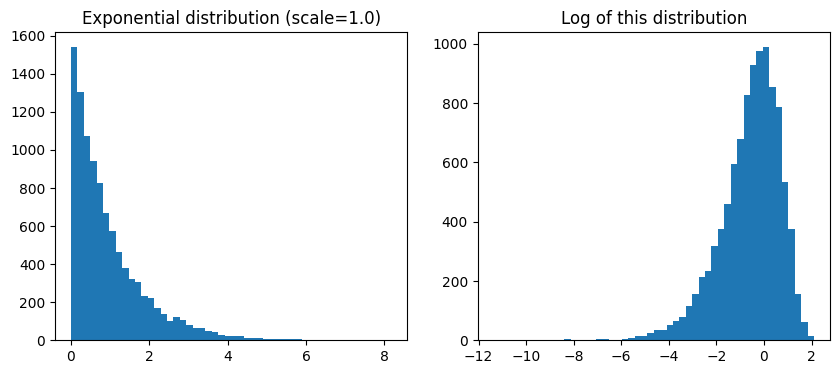

In [12]:
import matplotlib.pyplot as plt

expon_distrib = expon(scale=1.0)
sample = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(sample, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(sample), bins=50)
plt.show()

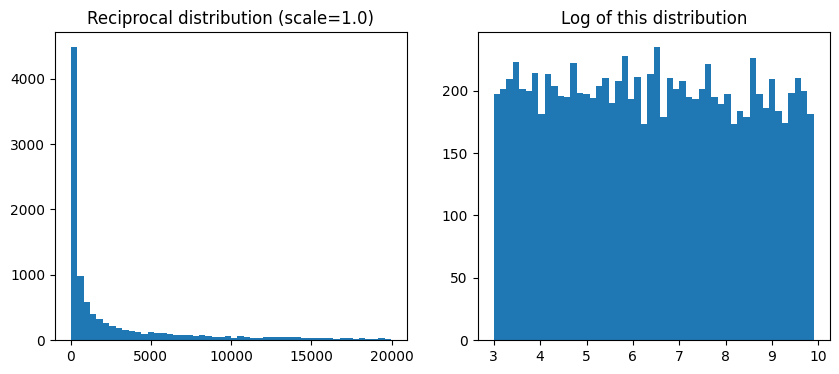

In [14]:
from scipy.stats import reciprocal

reciprocal_distrib = reciprocal(20, 20000)

sample = reciprocal_distrib.rvs(10000, random_state=42)

plt.figure(figsize=(10, 4))
plt.subplot(121)

plt.title("Reciprocal distribution (scale=1.0)")

plt.hist(sample, bins=50)
plt.subplot(122)

plt.title("Log of this distribution")

plt.hist(np.log(sample), bins=50)

plt.show()

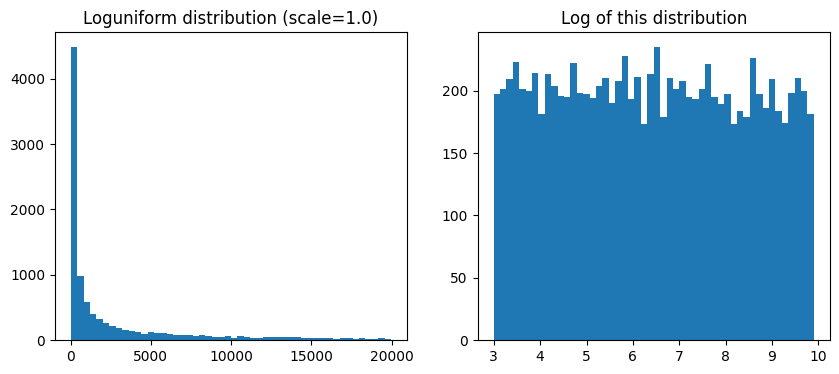

In [15]:
loguniform_distrib = loguniform(20, 20000)
sample = loguniform_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Loguniform distribution (scale=1.0)")
plt.hist(sample, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(sample), bins=50)
plt.show()